# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим все необходимые библиотеки. Прочитаем данные, выведем общую информацию и рассмотрим числовые признаки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.plotting import plot_importance
from catboost import CatBoostRegressor
from catboost import Pool, cv
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
import time
from sklearn.dummy import DummyRegressor
from tqdm import tqdm

In [ ]:
df=pd.read_csv('/datasets/autos.csv')

In [ ]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Перед нами датасет с большим количеством объектов, 15 признаками. Каждый объект представляет собой автомобиль выставленный на продажу.  
Первое, что бросается в глаза это "Верблюжий стиль" написания названий признаков и неверный тип признаков в колонках с датами, также присутствуют аномальные значения и естьь пропуски в некоторых данных. -> Приведем все названия признаков к "Змеиному регистру" и изменим тип данных.

In [ ]:
cols={'DateCrawled':'Date_Crawled',
     'VehicleType':'Vehicle_Type',
     'RegistrationYear':'Registration_Year',
     'RegistrationMonth':'Registration_Month',
      'FuelType':'Fuel_Type',
     'DateCreated':'Date_Created',
     'NumberOfPictures':'Num_Of_Pics',
     'PostalCode':'Postal_Code',
     'LastSeen':'Last_Seen'
    }
df=df.rename(columns=cols)
df.columns=df.columns.str.lower()

In [ ]:
df.date_crawled=pd.to_datetime(df.date_crawled)
df.date_created=pd.to_datetime(df.date_created)
df.last_seen=pd.to_datetime(df.last_seen)

Рассмотрим подробнее пропуски:

In [ ]:
round(df.isna().sum()/len(df)*100,2)

date_crawled           0.00
price                  0.00
vehicle_type          10.58
registration_year      0.00
gearbox                5.60
power                  0.00
model                  5.56
kilometer              0.00
registration_month     0.00
fuel_type              9.28
brand                  0.00
repaired              20.08
date_created           0.00
num_of_pics            0.00
postal_code            0.00
last_seen              0.00
dtype: float64

Наблюдаются пропуски в переменных 'vehicle_type' ~ 10.58%, 'gearbox' ~ 5.6%, 'model' ~ 5.56%, 'fuel_type' ~ 9.28% и 'repaired' ~ 20.08.

Приступим к анализу каждого пизнака по порядку, начнем с цены:

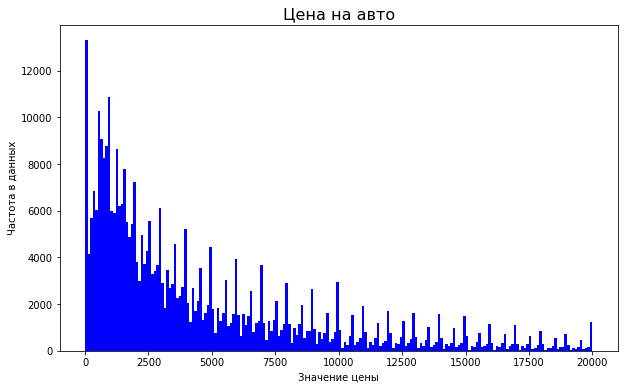

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=200,color='blue')
plt.xlabel('Значение цены')
plt.ylabel('Частота в данных')
plt.title('Цена на авто',fontsize=16)
plt.show()

Внимание привлекают нулевые и околонулевые значения - это явно аномальные значения:

In [ ]:
df.loc[df['price']==0]['price'].count()/len(df)*100

3.0397692800442475

Всего около 3% нулевых значений цены, рассмотрим подробнее диапазоны от 0 до 1000 и выше 20000:

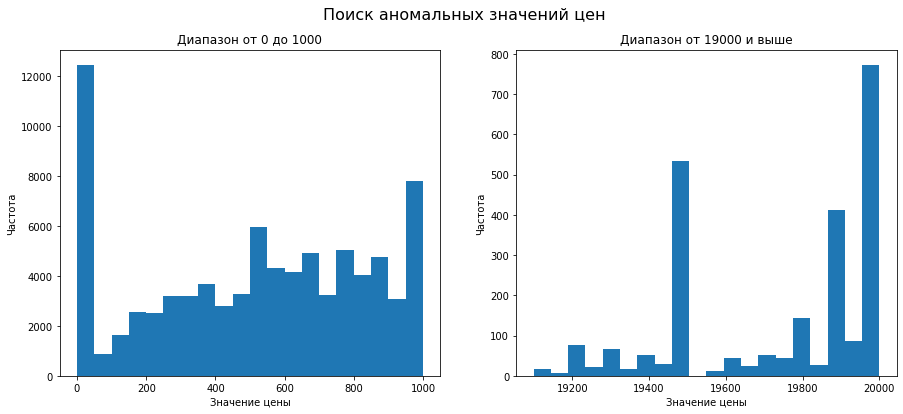

In [ ]:
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Поиск аномальных значений цен', fontsize=16)
ax1.hist(df.query('price<1000')['price'],bins=20)
ax1.set_xlabel('Значение цены')
ax1.set_ylabel('Частота')
ax1.set_title('Диапазон от 0 до 1000')

ax2.hist(df.query('price>19000')['price'],bins=20)
ax2.set_xlabel('Значение цены')
ax2.set_ylabel('Частота')
ax2.set_title('Диапазон от 19000 и выше')

plt.show()

Думаю рацональным оставить цену за авто хотя бы выше 100 евро.

In [ ]:
df=df.query('price>100')

Расмотрим тип автомобильного кузова:

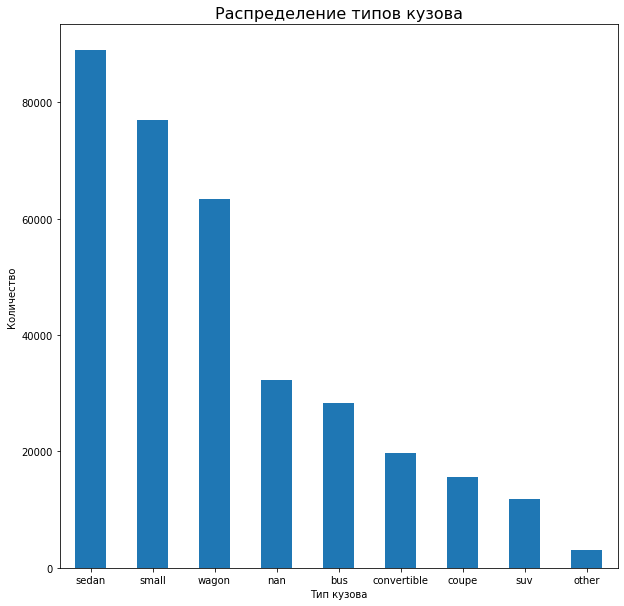

In [ ]:
df.vehicle_type.value_counts(dropna=False).plot(kind='bar', rot=0, figsize=(10,10))
plt.title('Распределение типов кузова', fontsize=16)
plt.xlabel('Тип кузова')
plt.ylabel('Количество')
plt.show()

В данном признаке присутствует около 40000 пропусков - заполним их "заглушкой".

In [ ]:
df.vehicle_type=df.vehicle_type.fillna('unknown')

Изучим год регистрации:

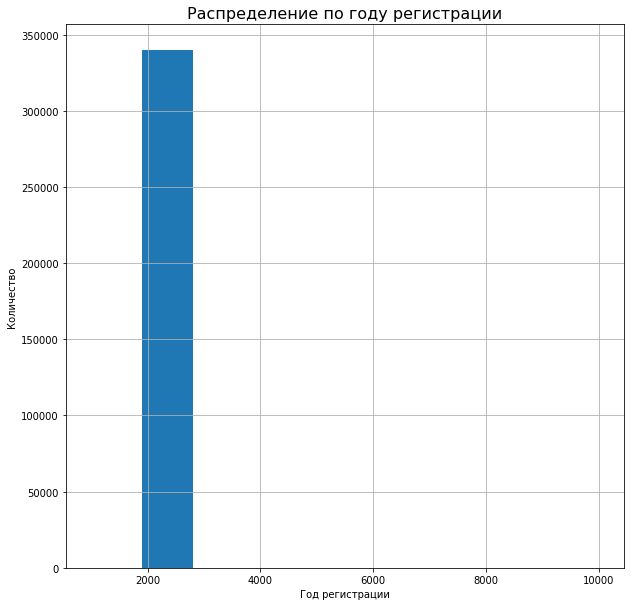

In [ ]:
df.registration_year.hist(figsize=(10,10))
plt.title('Распределение по году регистрации', fontsize=16)
plt.xlabel('Год регистрации')
plt.ylabel('Количество')
plt.show()

Разброс на оси x от 0 до 10000 предполагает наличие аномальных значений в признаке "registration_year". Найдем предполагаемый минимальный год регистрации (а не год выпуска!) - основываясь на здравом смысле отсекаем все даты до 1950 года :)

In [ ]:
np.sort(df.query('registration_year<1980')['registration_year'].unique())[::-1]

array([1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971, 1970, 1969,
       1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960, 1959, 1958,
       1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950, 1949, 1948, 1947,
       1946, 1945, 1944, 1943, 1942, 1941, 1940, 1938, 1937, 1936, 1935,
       1934, 1933, 1932, 1931, 1930, 1929, 1928, 1927, 1925, 1923, 1910,
       1800, 1602, 1600, 1500, 1400, 1300, 1234, 1111, 1039, 1001, 1000])

In [ ]:
min_year=1950

А теперь максимальный (год регистрации не может быть больше года заполнения анкеты):

In [ ]:
max_year = df['date_crawled'].dt.year.max()
print('Максимальное значение года анкетирования:',max_year)

Максимальное значение года анкетирования: 2016


In [ ]:
df=df.query('@min_year<=registration_year<=@max_year')

Пропуски в переменных "gearbox" и "model" предлагаю заполнить заглушкой:

In [ ]:
df.gearbox=df.gearbox.fillna('unknown')

In [ ]:
df.model=df.model.fillna('unknown')

Пропуски в переменной "power" заполним средним значением мощности по модели:

In [ ]:
df['power']=df.groupby('model')['power'].transform(lambda x: x.replace(0, x.mean()))

Проверим а наличие аномальных значений, нижний порог - 15 л.с., верхний - 1000 л.с.

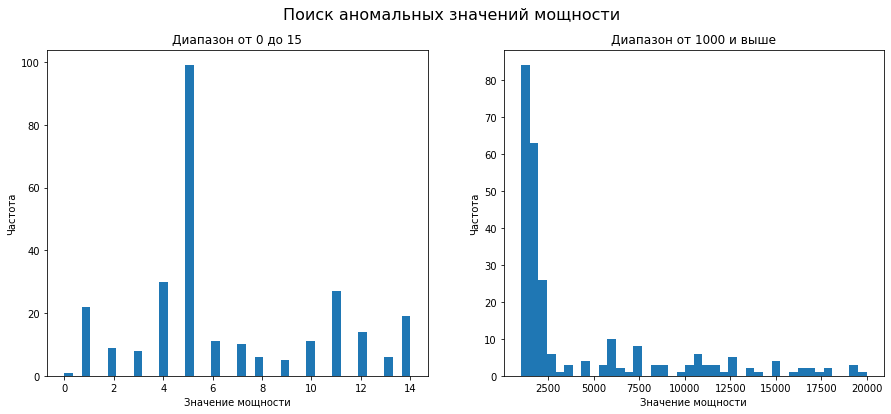

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Поиск аномальных значений мощности', fontsize=16)
ax1.hist(df.query('power<15').power, bins=40)
ax1.set_xlabel('Значение мощности')
ax1.set_ylabel('Частота')
ax1.set_title('Диапазон от 0 до 15')

ax2.hist(df.query('power>1000').power, bins=40)
ax2.set_xlabel('Значение мощности')
ax2.set_ylabel('Частота')
ax2.set_title('Диапазон от 1000 и выше')

plt.show()

Аномальных значений достаточно - уберем их.

In [ ]:
df=df.query('15<power<1000')

Переменная - пробег - в порядке:

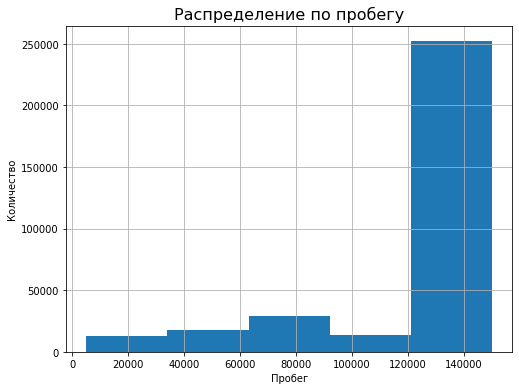

In [ ]:
df['kilometer'].hist(bins=5,figsize=(8,6))
plt.title('Распределение по пробегу', fontsize=16)
plt.xlabel('Пробег')
plt.ylabel('Количество')
plt.show()

В переменной - месяц - присутствует месяц = 0 + коэф корреляции практически равен 0. На мой взгляд такой признак оставлять нет смысла - добавим его в список на удаление:

In [ ]:
sorted(df.registration_month.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Пропуски в "fuel_type" и "repaired" заполним заглушкой:

In [ ]:
df.fuel_type.value_counts(dropna=False)

petrol      202623
gasoline     94415
NaN          22668
lpg           5008
cng            527
hybrid         219
other          140
electric        55
Name: fuel_type, dtype: int64

In [ ]:
df.fuel_type=df.fuel_type.fillna('unknown')

In [ ]:
df.repaired.value_counts(dropna=False)

no     235970
NaN     57726
yes     31959
Name: repaired, dtype: int64

In [ ]:
df.repaired=df.repaired.fillna('unknown')

В переменной - количество изображений - всего 1 значение = 0. Добавим его в список на удаление:

In [ ]:
df.num_of_pics.value_counts()

0    325655
Name: num_of_pics, dtype: int64

Переменную -почтовый индекс- нет смысла использовать, как числовый признак, он скорее подходит, как категориальный:

In [ ]:
df.postal_code.nunique()

8132

В нем аж 8132 уникальных значения, но коэф корреляции с целевым признаком практически = 0. Добавим эту переменную также в список на удаление + включем в него все переменные с датами.

In [ ]:
cols=['date_crawled','date_created','last_seen','num_of_pics','registration_month','postal_code']
df=df.drop(columns=cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325655 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              325655 non-null  int64  
 1   vehicle_type       325655 non-null  object 
 2   registration_year  325655 non-null  int64  
 3   gearbox            325655 non-null  object 
 4   power              325655 non-null  float64
 5   model              325655 non-null  object 
 6   kilometer          325655 non-null  int64  
 7   fuel_type          325655 non-null  object 
 8   brand              325655 non-null  object 
 9   repaired           325655 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.3+ MB


In [ ]:
percent=round(100-len(df)/len(pd.read_csv('/datasets/autos.csv'))*100,2)
print("По завершению обработки пропусков было удалено ~",percent,'% данных.')

По завершению обработки пропусков было удалено ~ 8.1 % данных.


**Вывод:** Проведена обработка данных, выполнен краткий анализ переменных, их взаимосвязи. Обнаружены и удалены аномальные значения и заполнены, где возмжно, пропуски в данных. Приступаем к поиску оптимальной модели.

## Обучение моделей

Для начала разделим датасет на обучающую, валидационную и тестовую выборки, а также выделим категориальные и числовые признаки для дальнейшего использования по ходу обучения.

In [ ]:
y=df.price
X=df.drop('price',axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [ ]:
cat_features=X_train.select_dtypes(include='object').columns.to_list()
num_features=X_train.select_dtypes(exclude='object').columns.to_list()

Для данного задания я выбрал три модели - LinearRegression, CatBoost, LightGBM. Обучим все три и проверим на валидационной выборке, сравним показатель RMSE.

**Линейная регрессия:**

Вызовем make_column_transformer - метод позволяющий проводить манипуляции над признаками - масштабировать непрерывные переменные и кодировать категориальные.

In [ ]:
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
y_train_lr=y_train.copy()
y_test_lr=y_test.copy()

In [ ]:
col_transformer_lr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),cat_features),
    (StandardScaler(), num_features),
    verbose_feature_names_out=False)

# трансформируем тренировочную выборку
X_train_lr = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lr.fit_transform(X_train_lr),
    columns=col_transformer_lr.get_feature_names_out())

In [ ]:
# трансформируем тестовую выборку
X_test_lr = pd.DataFrame.sparse.from_spmatrix(
    col_transformer_lr.transform(X_test_lr),
    columns=col_transformer_lr.get_feature_names_out()
)

Обучим линейную ререссию и вычислим время обучения и предсказаний c помощью метода GridSearchCV:

In [ ]:
model_lr=LinearRegression()
params_grid_lr={}
grid_search_lr = GridSearchCV(model_lr, params_grid_lr, cv=3,scoring='neg_mean_squared_error', error_score='raise')

In [ ]:
%%time
grid_search_lr.fit(X_train_lr, y_train_lr)

CPU times: user 37.8 s, sys: 1min 13s, total: 1min 51s
Wall time: 1min 51s


GridSearchCV(cv=3, error_score='raise', estimator=LinearRegression(),
             param_grid={}, scoring='neg_mean_squared_error')

Найдем лучший показатель RMSE:

In [ ]:
rmse_lr=np.sqrt(-grid_search_lr.best_score_)
print("RMSE Linear Regression:", round(rmse_lr,2))

RMSE Linear Regression: 2636.54


Рассчитаем время обучения и предсказания:

In [ ]:
start_time=time.time()

model_lr.fit(X_train_lr, y_train)

end_time=time.time()

time_fit_lr=end_time-start_time

In [ ]:
start_time=time.time()

y_pred = model_lr.predict(X_train_lr)

end_time=time.time()

time_pred_lr=end_time-start_time

print("Время обучения Linear Regression:", round(time_fit_lr,2),'сек')
print("Время предсказания Linear Regression:", round(time_pred_lr,5),'сек')

Время обучения Linear Regression: 32.83 сек
Время предсказания Linear Regression: 0.0341 сек


**LightGBM:**

Зададим категориальный тип переменным для обучения модели и заново разделим датасет на тренировочную и тестовую выборки:

In [ ]:
for c in cat_features:
    df[c]=df[c].astype('category')

In [ ]:
y=df.price
X=df.drop('price',axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

Для поиска гиперпараметров модели применим GridSearchCV:

In [ ]:
fixed_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':42
}

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.2],
}


base_model = lgb.LGBMRegressor(**fixed_params)
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='neg_mean_squared_error',cv=3)

In [ ]:
%%time
grid_search.fit(X_train, y_train)

rmse_lgb = np.sqrt(-grid_search.best_score_)
print("Наилучшие параметры: ", grid_search.best_params_)
print("Наилучший результат RMSE LightGBM: ", rmse_lgb )

Наилучшие параметры:  {'learning_rate': 0.2, 'num_leaves': 50}
Наилучший результат RMSE LightGBM:  1604.9807307480821
CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 1min 15s


Теперь обновим сетку гиперпараметров модели, создадим класс Dataset для обучения и запустим сам процесс обучения и предсказаний для фикцации времени:

In [ ]:
params_lgb = {
    'learning_rate': 0.2,
    'num_leaves': 50,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':42
}

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)

In [ ]:
start_time=time.time()

model_lgb = lgb.train(params_lgb, train_data, num_boost_round=100)

end_time=time.time()

time_train_lgb=end_time-start_time

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 195393, number of used features: 9
[LightGBM] [Info] Start training from score 4662.238647


In [ ]:
start_time=time.time()

y_pred = model_lgb.predict(X_train)

end_time=time.time()
time_pred_lgb=end_time-start_time

In [ ]:
print("Время обучения LightGBM:", round(time_train_lgb,2),'сек')
print("Время предсказания LightGBM:", round(time_pred_lgb,5),'сек')

Время обучения LightGBM: 14.17 сек
Время предсказания LightGBM: 1.80124 сек


**CatBoostRegressor:**

Подберем гипрепараметры для модели CatBoostRegressor **GridSearchCV**.

In [ ]:
param_fixed={'loss_function':'RMSE',
             'random_seed':42,
             'cat_features':cat_features,
             'verbose':False}


param_grid_cb = {'learning_rate': [0.1,0.2],
              'depth': [6, 8]}

model_cb = CatBoostRegressor(**param_fixed)

In [ ]:
%%time
grid_search_cb = GridSearchCV(model_cb, param_grid_cb, cv=3, scoring='neg_mean_squared_error',error_score='raise')
grid_search_cb.fit(X_train, y_train)

CPU times: user 38min 50s, sys: 21.3 s, total: 39min 11s
Wall time: 39min 35s


GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f507b835ca0>,
             param_grid={'depth': [6, 8], 'learning_rate': [0.1, 0.2]},
             scoring='neg_mean_squared_error')

In [ ]:
rmse_cb = np.sqrt(-grid_search_cb.best_score_)
print("Наилучшие параметры:", grid_search.best_params_)
print("Наилучшее значение метрики:", rmse_cb)

Наилучшие параметры: {'learning_rate': 0.2, 'num_leaves': 50}
Наилучшее значение метрики: 1592.188362241379


Теперь создадим ПУЛ и рассчитаем время обучения и предсказания.

In [ ]:
train_data=Pool(X_train,y_train,cat_features=cat_features)

In [ ]:
params_cb={
    'learning_rate':0.2,
    'depth':8,
    'loss_function':'RMSE',
    'random_seed':42
}

In [ ]:
model_cb = CatBoostRegressor(**params_cb,verbose=False)

In [ ]:
start_time=time.time()

model_cb.fit(train_data)

end_time=time.time()

time_train_cb=end_time-start_time

In [ ]:
start_time=time.time()

y_pred=model_cb.predict(X_train)

end_time=time.time()

time_pred_cb=end_time-start_time

In [ ]:
print("Время обучения CatBoostRegressor:", round(time_train_cb,2),'сек')
print("Время предсказания CatBoostRegressor:", round(time_pred_cb,5),'сек')

Время обучения CatBoostRegressor: 308.46 сек
Время предсказания CatBoostRegressor: 3.28694 сек


**Сравнение моделей:**

In [ ]:
metrics=['rmse','time_train','time_pred']
columns=['Linear_Regression','LightGBM_Regression', 'CatBoost_Regression']
rmse=[round(rmse_lr,2),round(rmse_lgb,2), round(rmse_cb,2)]
time_train=[round(time_fit_lr,2), round(time_train_lgb,2),round(time_train_cb,2)]
time_pred=[round(time_pred_lr,5), round(time_pred_lgb,5),round(time_pred_cb,5)]

comparassion=pd.DataFrame(data=[rmse,time_train,time_pred], columns=columns, index=metrics)
comparassion

,Linear_Regression,LightGBM_Regression,CatBoost_Regression
rmse,2636.5400,1604.98000,1592.19000
time_train,32.8300,14.17000,308.46000
time_pred,0.0341,1.80124,3.28694


**Вывод:** Обучив три модели, выделим лидера по RMSE - CatBoost. Хотя модель и обучается дольше остальных (но сравнительно недолго), метрика RMSE - самая лучшая. Переходим анализу лучшей модели.

## Анализ лучшей модели

**CatBoost:**

In [ ]:
y_pred=model_cb.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE CatBoost на тестовой выборке:",rmse)

RMSE CatBoost на тестовой выборке: 1551.9187209922231


In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred,alpha=0.3)
plt.xlabel("Expected")
plt.ylabel("Predicted")
plt.title("Predicted vs Expected")
plt.show()

In [ ]:
importance = model_cb.feature_importances_
names = X.columns
feature_importance = pd.DataFrame({'feature': names, 'importance': importance})
feature_importance.sort_values(by='importance', inplace=True)
feature_importance.set_index('feature', inplace=True)
feature_importance.plot(kind='barh', figsize=(5, 5))
plt.xlabel('Importance')
plt.title('Feature importance')
plt.show()


* у модели самый лучший показатель RMSE
* модель не очень хорошо предсказывает слишком маленькие и слишком большие значения (большой разброс в таргетах и предсказаниях на этих участках)
* ключевые признаки это - "registration year", "power" и "vehicle_type"

Проверим модель на адекватность используя Dummy модель:

In [ ]:
model= DummyRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
rmse_dm=np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE DummyRegressor:',rmse_dm)

Значение полученной метрики в разы больше метрики нашей модели, что подтверждает адекватность CatBoostRegressor.

**Вывод:** Нам были переданы данные о стоимости и характеристиках автомобилей для сервиса "Не бит, не крашен". Задача - найти лучшую модель предсказаний цен на авто.  
После предабработки данных, по ходу который мы:
* избавились от аномальных значений в данных,
* заполнили пропущенные значения, где это возможно,
* оставили только реально важные признаки для обучения

Был проведен этап обучения трех моделей: LinearRegression, CatBoost, LightGBM. Были подобраны оптимальные гиперпараметры для каждой.  
Лучшую скорость обучения показала Линейная Регрессия, лучший показатель RMSE и скорость предсказаний - CatBoost.
Далее проведен более подробный анализ на тестовой выборке - после которого лидерство CatBoost подтвердилось.